This file will compare the METE predicted MRDIs to the empirical MRDIs. Doing this is a little complicated since we only have mean body mass, so we have to simulated noise from the body mass distribution before doing the comparison, then convert to metabolic rate. 

There are a lot of approximations here -- the mass is calculated empirically from the length, the mean mass has noise added to it assuming a normal distribution with variance from a regression relationship (see BodyMassVariance), and is then converted into a metabolic rate. I don't necessarily trust these results that much, but the hope is that we will see similar results to what we got with the SADs to back those results.

In [27]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy import integrate
import sad_mrdi as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# Read in only adult data set, because it has body mass information
# Unfortunately for spiders there is only one mean represented
ad = pd.read_csv('./RawData/Azores_Adults.csv',header=[0,1])
# Get land use types
lu = list(ad.columns.levels[0])
lu.remove('Data')
# Reorder to disturbance gradient
lu = [lu[2],lu[0],lu[3],lu[1]]
# Make arrays
# For s,n,beta. Later e0 and lambdas.
sne = pd.DataFrame(index=lu,columns = {'s0','n0','e0','beta','l1','l2'})
# For abundances
abd = pd.DataFrame(columns=lu)
for l in lu:
    abd[l] = ad[l].sum(axis=1)
    # Get n0 and s0
    stemp = np.count_nonzero(abd[l])
    ntemp = abd[l].sum()
    # Get beta
    btemp = sm.get_beta(stemp,ntemp)
    # Add to dataframe
    sne.loc[l] = {'n0': ntemp, 's0': stemp, 'beta': btemp}
    
# Rename indexes for abundaces to species code
abd.rename(index=ad['Data','MF'],inplace=True)
abd.index.name = 'MF'

# Fix datatype for sne_lu
sne = sne.astype({'s0': 'int64','n0':'int64','beta':'float64'})

# Preamble

Look by order. We have regression relationships between mean and variance for spiders and beetles. Beetles seem roughly normally distributed for how many data points we have, and spiders are probably bimodal due to sex, but we only have access to the central mean so we will pretend they are characterized by mean and variance as well. The other orders: Blattaria are termites, Dermaptera are earwigs, Geophilomorpha are centipedes, Hemiptera are true bugs, Julida are millipedes, Lithobiomorpha are stone centipedes, Microcoryphia are bristletails, Opiliones are harvestmen, Orthoptera are locusts and crickets, Polydesmida are another type of millipede, Pseudoscorpiones are pseudoscorpions, Psocoptera are booklice, Scolopendromorpha are large centipedes, Scutigeromorpha are house centipedes, Symphyla are pseudocentipedes, Thysanoptera are thrips which are related to hemiptera and psocoptera, and finally Trichoptera are caddisflies.

In [29]:
# Print orders and how many per
for o in ad['Data','Order (new)'].unique():
    print("{}\t\tSpecies {}\t\tIndividuals".format(
        o,ad[ad['Data','Order (new)']==o]['Data','Species_name'].nunique()),
         ad[ad['Data','Order (new)']==o].drop(columns='Data',level=0).sum().sum())

Araneae		Species 41		Individuals 22040
Blattaria		Species 1		Individuals 10
Coleoptera		Species 110		Individuals 9173
Dermaptera		Species 2		Individuals 367
Geophilomorpha		Species 1		Individuals 8
Hemiptera		Species 31		Individuals 736
Julida		Species 5		Individuals 1071
Lithobiomorpha 		Species 2		Individuals 1520
Microcoryphia		Species 2		Individuals 10
Opiliones		Species 2		Individuals 597
Orthoptera		Species 2		Individuals 440
Polydesmida		Species 3		Individuals 95
Pseudoscorpiones		Species 2		Individuals 152
Psocoptera		Species 4		Individuals 6
Scolopendromorpha		Species 1		Individuals 7
Scutigeromorpha		Species 1		Individuals 4
Symphyla		Species 1		Individuals 1
Thysanoptera		Species 5		Individuals 31
Trichoptera		Species 1		Individuals 1


In [30]:
# How much percent are araneae and beetles?
print((22040+9173)/ad.drop(columns='Data',level=0).sum().sum())
# So at least it is most of the dataset. Let's use the beetle regression for all for now.

0.860597204223993


In [31]:
# Set up regression relationships from BodyMassVariance.ipynb
# Note these are for the log relationship
# For beetles
bi = -1.243073857459273
bs = 1.9948767678521848
# For spiders
si = -1.1467463900692998
ss = 2.2207391333864335

# Make simulated datasets
Generate a biomass array from the data using the mean and pulling the appropriate number from a normal distribution.

To improve this, I could use the actual variances for the species I have in the BodyMassVariance notebook, and could use the dimorphism for the spiders from there, but I'm not sure it actually makes sense because the data is slightly different, and only available for some species. Let's stick with the easiest thing for now.

In [32]:
# Set random seed
prng = np.random.RandomState(101)
# Make a dictionary with labeled land uses
biomass = {}
for l in lu:
    # Find args for this land use where the abundance is non-zero
    args_temp = np.where(abd[l])[0]
    # Get abundances just for this land use
    abd_temp = abd[l].iloc[args_temp]
    # Now simulate that number of points for each species
    biomass[l] = np.array([])
    for mf in abd_temp.index:
        # pull abd_temp[mf] number of points from a normal distribution
        # where the mean is given by the mean in the main dataset
        # and the standard deviation is given by the regression relationships above
        mean = ad[ad['Data','MF']==mf]['Data','Body_Mass.mg.']
        # Use the beetle regression
        if (ad[ad['Data','MF']==mf]['Data','Order (new)'].values[0]=='Araneae'):
            var = 10**(si+ss*np.log10(mean))
        else:
            var = 10**(bi+bs*np.log10(mean))
        biomass[l] = np.append(biomass[l],
                               st.norm.rvs(loc=mean,scale=np.sqrt(var),size=abd_temp[mf],random_state=prng))
        # There is an issue here where depending on random seed we can get biomasses below zero, 
        # but let's ignore that.

In [33]:
# Check for less than zeros. These should be empty if adding the variance in is working.
for l in lu:
    print(biomass[l][biomass[l]<0])

[]
[]
[]
[]


In [34]:
# Now convert to metabolic rate
mr = biomass.copy()
for l in lu:
    # Now sort the array, convert to metabolic rate (m \propto e^(4/3)), and divide by smallest
    # Order doesn't matter here
    mr[l] = np.sort(mr[l]**(3/4))
    # Note that this way, the e0 between the land uses actually isn't comparable 
    #because the smallest unit is different
    mr[l] = mr[l]/mr[l][0]
    
for l in lu:
    sne.loc[l,'e0'] = mr[l].sum()
sne['l2'] = sne['s0']/(sne['e0']-sne['n0'])
sne['l1'] = sne['beta']-sne['l2']

In [35]:
sne

,n0,e0,beta,l1,l2,s0
Native forest,4404,2.63914e+06,0.004430,0.00438936,4.02318e-05,106
Exotic forest,2651,299585,0.005849,0.00557945,0.00026942,80
Semi-natural pasture,9846,809605,0.001760,0.00162208,0.000137541,110
Intensive pasture,19368,4.17182e+06,0.000932,0.000901397,3.03435e-05,126


# KS Goodness of fit and plots

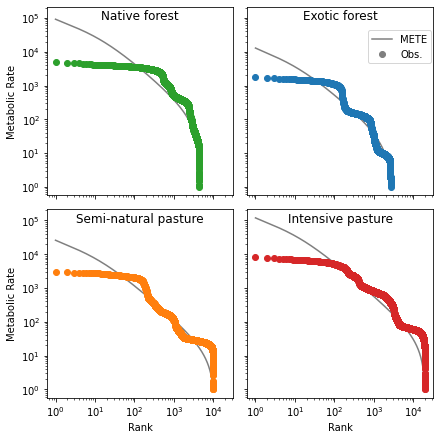

In [36]:
# With better colour scheme
clist = {lu[0]:'tab:green',lu[1]:'tab:blue',lu[2]:'tab:orange',lu[3]:'tab:red'}
fig,axs = plt.subplots(2,2,figsize=(6,6),sharex=True,sharey=True,constrained_layout=True)
for l, ax in zip(lu,fig.axes):
    # Set title to index
    ax.set_title(l,y=0.9)
    # Plot theoretical MRDI
    ranks = np.arange(sne.loc[l,'n0'])+1
    ax.loglog(ranks,sm.mrdi_rank(ranks,(sne.loc[l,'l1'],sne.loc[l,'l2']),sne.loc[l,'n0']),c='tab:gray',label='METE')
    # Plot empirical MRDI
    ax.loglog(ranks,mr[l][::-1],'o',c=clist[l],label='Obs.')
    
mete, = axs[0,1].semilogy([],[],c='tab:gray',label='METE')
obs, = axs[0,1].semilogy([],[],'o',c='tab:gray',label='Obs.')

axs[0,1].legend(handles=[mete,obs],loc=(0.65,0.7))#'center right')

axs[0,0].set_ylabel('Metabolic Rate')
axs[1,0].set_ylabel('Metabolic Rate')
axs[1,0].set_xlabel('Rank')
axs[1,1].set_xlabel('Rank')

fig.savefig('Figures/SI/MRDI_combined.pdf')

# Least squares goodness of fit

In [37]:
# Use mean least squares as with SAD
mlsq = pd.Series(index=lu,dtype='float64')
for l in lu:
    ranks = np.arange(sne.loc[l,'n0'])+1
    pred = sm.mrdi_rank(ranks,(sne.loc[l,'l1'],sne.loc[l,'l2']),sne.loc[l,'n0'])
    print(pred[-1]) # These should be 1
    obs = mr[l][::-1]
    if sne['n0'][l] == len(obs):
        mlsq[l] = np.sum((np.log(obs)-np.log(pred))**2)/len(obs)
    else:
        print("Ruh ro!")

sne['mlsq'] = mlsq
sne.to_csv('ProcessedData/mrdi_combined_data.csv')
display(sne)

1.0124739876046562
1.0040833347752947
1.0006491360254754
1.0007923621011034


,n0,e0,beta,l1,l2,s0,mlsq
Native forest,4404,2.63914e+06,0.004430,0.00438936,4.02318e-05,106,0.378824
Exotic forest,2651,299585,0.005849,0.00557945,0.00026942,80,0.260345
Semi-natural pasture,9846,809605,0.001760,0.00162208,0.000137541,110,1.253413
Intensive pasture,19368,4.17182e+06,0.000932,0.000901397,3.03435e-05,126,1.391150
